# Rewrite Code - Diffusion model
改變：
1. 只有$y_0$從 normal 裡面抽，沒有$x$
2. 'and not DETERMINISTIC' 拿掉
3. 輸出要看到eps

sorce code: Simple file

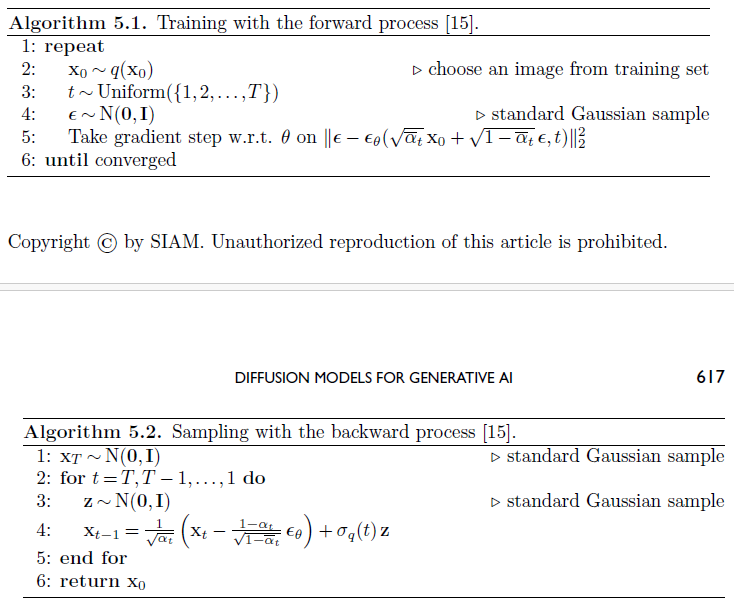


In [1]:
import math, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt

### Con fig

In [2]:
DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 256
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 2e-3
HIDDEN        = 128
TIME_DIM      = 64
N_TRAIN_SAMP  = 4096       # 訓練資料量）


In [3]:
### Constants setting
betas = torch.linspace(1e-4, 0.02, T, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)

In [4]:
### 這塊留給 time embedding
### 先不要放試試看

In [ ]:
## 建nn
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.t_proj = nn.Sequential(nn.Linear(time_dim, hidden), nn.SiLU())
        self.net = nn.Sequential(
            nn.Linear(hidden+2, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden,1)
        )
    def forward(self, y_t, t):
        h_t = self.proj(t)        ####<<<---這裡t原本要放time embdding
        h = torch.cat([y_t, h_t], dim=1)
        return self.net(h)

model = EpsMLP().to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)

In [ ]:
### 計算 y_t= sqrt(abar_t) y0 + sqrt(1-abar_t) * eps
# ---------------------
def q_sample(y0, t, eps=None):
    if eps is None:
        eps = torch.randn_like(y0)   ## 產生跟y0大小一樣的初始normal雜訊
    sa = sqrt_abar[t].view(-1,1)
    som = sqrt_lmabar[t].view(-1,1)
    return sa*y0+som*eps, eps


## Algorithm 1
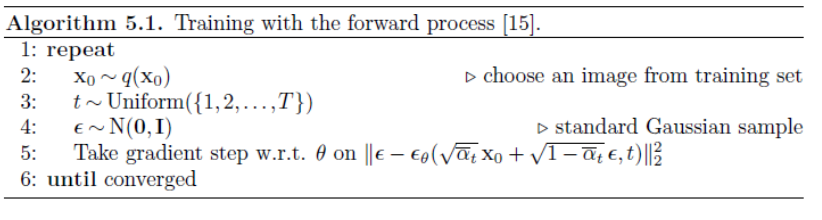

In [9]:
def train_loop():
    model.train()
    for step in range(1, TRAIN_ITERS+1):
        # 取 y0~N(-1,1)
        y0 = torch.randn(BATCH_SIZE, 1, device=DEVICE)
        # 隨機time step
        t = torch.randint(2,T+1, (BATCH_SIZE,),device=DEVICE).long()
        # 向前加噪
        y_t, eps = q_sample(y0,t)
        # 預測噪音
        eps_hat = model(y_t, t)      ####<----已經把x去掉
        loss = F.mse_loss(eps_hat, eps)

        opt.zero_grad(set_to_none = True) ##要清空上次的gradient否則會累加
        loss.backward()
        #把L2norm限制在1.0以內避免梯度爆炸 ; 但如果loss穩定可以不用
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % 100 ==0: ##每100步print紀錄一下
            print(f"[train] step {step:4d} | loss {loss.item():.6f}")
        

